In [0]:
!pip install tensorflow==2

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

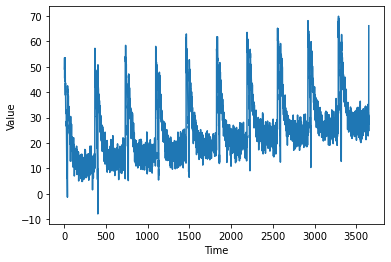

In [4]:
time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [9]:
from tensorflow.keras.layers import Lambda, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  Bidirectional(LSTM(units=32, return_sequences=True)),
  Bidirectional(LSTM(units=32, return_sequences=True)),
  Bidirectional(LSTM(units=32)),
  Dense(1),
  Lambda(lambda x: x * 10.)
])

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)

model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 10s 110ms/step - loss: 22.0122 - mae: 22.3828
Epoch 2/100
94/94 [==============================] - 3s 35ms/step - loss: 21.8528 - mae: 22.3641
Epoch 3/100
94/94 [==============================] - 3s 36ms/step - loss: 21.8393 - mae: 22.3429
Epoch 4/100
94/94 [==============================] - 3s 36ms/step - loss: 21.8131 - mae: 22.3191
Epoch 5/100
94/94 [==============================] - 3s 36ms/step - loss: 21.7866 - mae: 22.2925
Epoch 6/100
94/94 [==============================] - 3s 36ms/step - loss: 21.7659 - mae: 22.2626
Epoch 7/100
94/94 [==============================] - 3s 35ms/step - loss: 21.7313 - mae: 22.2291
Epoch 8/100
94/94 [==============================] - 3s 35ms/step - loss: 21.6979 - mae: 22.1916
Epoch 9/100
94/94 [==============================] - 3s 35ms/step - loss: 21.6478 - mae: 22.1494
Epoch 10/100
94/94 [==============================] - 3s 36ms/step - loss: 21.6039 - mae: 22.1020
Epoch 11/100
94/94 [=======

(1e-08, 0.0001, 0.0, 30.0)

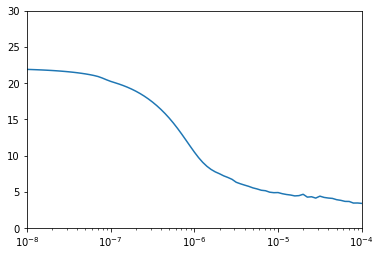

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  Bidirectional(LSTM(units=32, return_sequences=True)),
  Bidirectional(LSTM(units=32, return_sequences=True)),
  Bidirectional(LSTM(units=32)),
  Dense(1),
  Lambda(lambda x: x * 10.)
])

early_stopping = EarlyStopping(monitor='mae', min_delta=0.0001, patience=5)
model.compile(loss="mse", optimizer=SGD(lr=1e-4, momentum=0.9), metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, callbacks=[early_stopping])
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
94/94 [==============================] - 10s 108ms/step - loss: 98.4471 - mae: 6.8596
Epoch 2/500
94/94 [==============================] - 4s 37ms/step - loss: 44.1361 - mae: 4.3765
Epoch 3/500
94/94 [==============================] - 4s 38ms/step - loss: 33.9953 - mae: 3.9083
Epoch 4/500
94/94 [==============================] - 4s 38ms/step - loss: 27.4866 - mae: 3.5378
Epoch 5/500
94/94 [==============================] - 4s 39ms/step - loss: 28.0926 - mae: 3.5938
Epoch 6/500
94/94 [==============================] - 4s 39ms/step - loss: 26.9329 - mae: 3.5883
Epoch 7/500
94/94 [==============================] - 4s 39ms/step - loss: 27.5004 - mae: 3.6151
Epoch 8/500
94/94 [==============================] - 3s 37ms/step - loss: 24.6286 - mae: 3.3747
Epoch 9/500
94/94 [==============================] - 4s 38ms/step - loss: 25.0231 - mae: 3.4281
Epoch 10/500
94/94 [==============================] - 4s 38ms/step - loss: 22.9985 - mae: 3.2453
Epoch 11/500
94/94 [=================

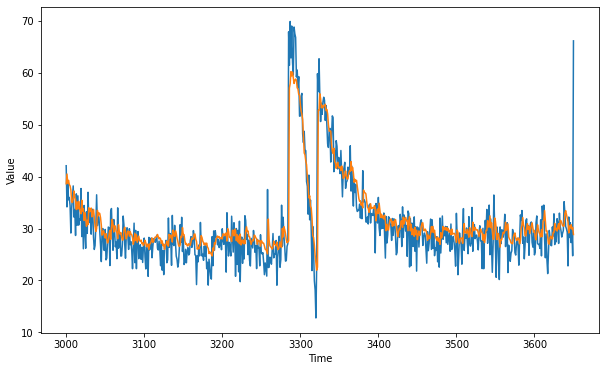

In [13]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

3.1085193

<Figure size 432x288 with 0 Axes>

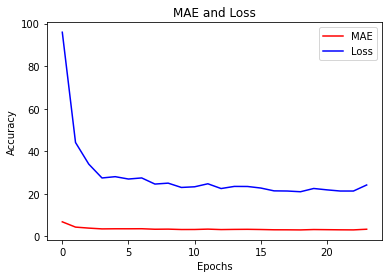

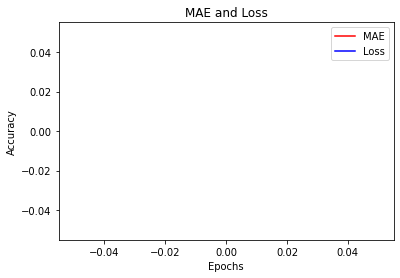

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()